In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-06-18 20:28:46.982310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750278527.213878      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750278527.279401      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# ЭТАП 1. Анализ и подготовка данных

## 1.1 📁 Загрузка и обзор структуры данных

In [2]:
for folder in ['train', 'val', 'test']:
    path = f"/kaggle/input/chest-xray-pneumonia/chest_xray/{folder}"
    counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in ['NORMAL', 'PNEUMONIA']}
    print(f"{folder} set:", counts)

train set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
val set: {'NORMAL': 8, 'PNEUMONIA': 8}
test set: {'NORMAL': 234, 'PNEUMONIA': 390}


Видно, насколько несбалансированы классы, особенно в тренировочной выборке. Это стоит учитывать при обучении модели.

## 1.2 📊 Визуализация дисбаланса классов

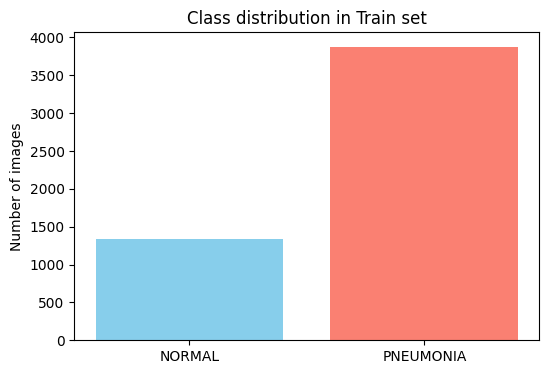

In [3]:
labels = ['NORMAL', 'PNEUMONIA']
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

train_counts = [len(os.listdir(os.path.join(train_path, label))) for label in labels]

plt.figure(figsize=(6,4))
plt.bar(labels, train_counts, color=['skyblue', 'salmon'])
plt.title('Class distribution in Train set')
plt.ylabel('Number of images')
plt.show()

Класс PNEUMONIA сильно преобладает. Может потребоваться взвешивание классов или аугментация для балансировки

## 1.3 🖼️ Примеры изображений из каждого класса

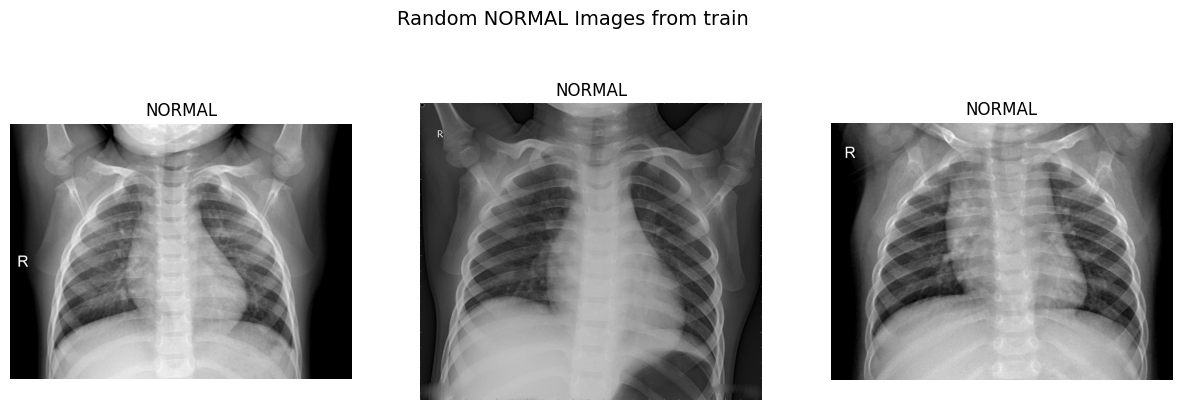

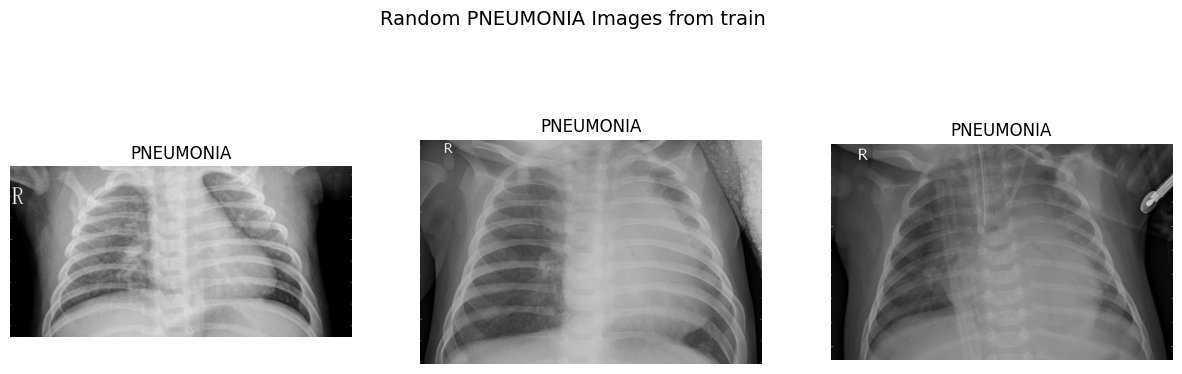

In [4]:
def show_random_images(label, n=3, dataset='train'):
    folder = f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}"
    images = os.listdir(folder)
    selected = np.random.choice(images, n)
    
    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label}")
        plt.axis('off')
    plt.suptitle(f"Random {label} Images from {dataset}", fontsize=14)
    plt.show()

show_random_images('NORMAL')
show_random_images('PNEUMONIA')

У изображений PNEUMONIA часто наблюдается выраженное затемнение и размытость. NORMAL — чище и с ровной структурой лёгких.

## 1.4 ⚠️ Поиск атипичных или подозрительных снимков

In [5]:
def find_atypical_images(label, dataset='train'):
    folder = Path(f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}")
    atypicals = []
    for file in folder.iterdir():
        try:
            img = Image.open(file)
            if img.size[0] < 100 or img.size[1] < 100:  # слишком маленькое изображение
                atypicals.append((file.name, img.size))
        except:
            atypicals.append((file.name, 'Unreadable'))
    return atypicals

atypical_normal = find_atypical_images('NORMAL')
atypical_pneumonia = find_atypical_images('PNEUMONIA')

print("Atypical NORMAL:", atypical_normal[:3])
print("Atypical PNEUMONIA:", atypical_pneumonia[:3])

Atypical NORMAL: []
Atypical PNEUMONIA: []


Маленькие или некорректные изображения могут повлиять на обучение и должны быть исключены.

## 1.5 🔁 Препроцессинг (обзор и план)

| Шаг          | Метод                   | Обоснование                              |
| ------------ | ----------------------- | ---------------------------------------- |
| Resize       | до 224×224              | Требуется большинством CNN               |
| Нормализация | \[-1, 1]                | MobileNetV2 ожидает такие входные данные |
| Аугментация  | поворот ±10°, флип, шум | Улучшает обобщающую способность модели   |


На этапе генерации датасета для обучения будем использовать ImageDataGenerator с этими параметрами.

## 1.6 📈 Подготовка к аугментации (черновик, без применения)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.1  # выделим немного на валидацию из train
)

test_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1
)

Аугментация будет применяться только к тренировочным изображениям. Тест и валидируем на оригинальных.